In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
import cace
from cace.representations.cace_representation import Cace

In [4]:
from ase.io import read,write

In [5]:
cutoff = 5.29
batch_size = 100

In [6]:
train_xyz_dir = '../4HDNNP-data/datasets/Ag_cluster/Ag-cluster.xyz'

In [7]:
collection = cace.tasks.get_dataset_from_xyz(train_path=train_xyz_dir,
                                 valid_fraction=0.1,
                                cutoff=cutoff,
                                 data_key={'energy': 'energy', 
                                           'forces': 'forces',
                                           'charge_states': 'charge_states'
                                          },
                                   atomic_energies = {47: -146385.11440723907}
                                    )

In [8]:
train_loader = cace.tasks.load_data_loader(collection=collection,
                              data_type='train',
                              batch_size=batch_size,
                                          )

In [9]:
valid_loader = cace.tasks.load_data_loader(collection=collection,
                              data_type='valid',
                              batch_size=batch_size)

In [10]:
device = cace.tools.init_device('cpu')

In [11]:
sampled_data = next(iter(train_loader))

In [12]:
sampled_data = sampled_data.to(device)

In [13]:
sampled_data

Batch(atomic_numbers=[300], batch=[300], cell=[300, 3], charge_states=[300], edge_index=[2, 556], energy=[100], forces=[300, 3], positions=[300, 3], ptr=[101], shifts=[556, 3], unit_shifts=[556, 3])

In [14]:
from cace.modules import CosineCutoff, MollifierCutoff, PolynomialCutoff
from cace.modules import BesselRBF, GaussianRBF, GaussianRBFCentered

In [15]:
radial_basis = BesselRBF(cutoff=cutoff, n_rbf=6, trainable=False)
cutoff_fn = PolynomialCutoff(cutoff=cutoff, p=5)

In [16]:
cace_representation = Cace(
    zs=[47],
    n_atom_basis=1,
    cutoff=cutoff,
    cutoff_fn=cutoff_fn,
    radial_basis=radial_basis,
    n_radial_basis=8,
    max_l=3,
    max_nu=3,
    num_message_passing=0,
    device=device,
    timeit=False,
    forward_features=['charge_states']
           )

In [17]:
from cace.models.atomistic import NeuralNetworkPotential

In [18]:
atomwise = cace.modules.Atomwise(
    feature_key = ['node_feats', 'charge_states'], 
    n_layers=3,
    n_hidden=[24,12],
    n_out=1,
    output_key='CACE_energy_intra',
    residual=False,
    add_linear_nn=True,
    bias=True)

In [19]:
forces = cace.modules.Forces(energy_key='CACE_energy_intra',
                                    forces_key='CACE_forces_intra')

In [20]:
from cace.models.atomistic import NeuralNetworkPotential

In [21]:
cace_nnp_intra = NeuralNetworkPotential(
    input_modules=None,
    representation=cace_representation,
    output_modules=[atomwise,  forces]
)

In [22]:
res = cace_nnp_intra(sampled_data)

In [23]:
sampled_data

Batch(atomic_numbers=[300], batch=[300], cell=[300, 3], charge_states=[300], edge_index=[2, 556], energy=[100], forces=[300, 3], positions=[300, 3], ptr=[101], shifts=[556, 3], unit_shifts=[556, 3])

In [24]:
from cace.models import CombinePotential

In [25]:
pot1 = {'CACE_energy': 'ewald_potential_2', 
        'CACE_forces': 'ewald_forces_2',
        'weight': 1.
       }

pot2 = {'CACE_energy': 'CACE_energy_intra', 
        'CACE_forces': 'CACE_forces_intra',
       }

In [26]:
#combo_p = CombinePotential([nnp_lr, cace_nnp_intra], [pot1,pot2])
combo_p = CombinePotential([cace_nnp_intra], [pot2])

In [27]:
from cace.tasks import GetLoss

In [28]:
energy_loss = GetLoss(
    target_name='energy',
    predict_name='CACE_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=0.1
)

In [29]:
energy_loss_2 = GetLoss(
    target_name='energy',
    predict_name='CACE_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=100
)

In [30]:
energy_loss_3 = GetLoss(
    target_name='energy',
    predict_name='CACE_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=100000
)

In [52]:
energy_loss_4 = GetLoss(
    target_name='energy',
    predict_name='CACE_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1000000
)

In [31]:
force_loss = GetLoss(
    target_name='forces',
    predict_name= 'CACE_forces',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1000
)

In [32]:
force_loss_2 = GetLoss(
    target_name='forces',
    predict_name= 'CACE_forces',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=100
)

In [33]:
from cace.tools import Metrics

In [34]:
e_metric = Metrics(
    target_name='energy',
    predict_name='CACE_energy',
    name='e/atom',
    per_atom=True
)

In [35]:
f_metric = Metrics(
    target_name='forces',
    predict_name='CACE_forces',
    name='f'
)

In [36]:
sampled_dict = sampled_data.to_dict()

In [37]:
sampled_data_result = combo_p(sampled_dict, training=True)

In [38]:
energy_loss_3(sampled_data_result, sampled_data)

tensor(1741124.3750, grad_fn=<MulBackward0>)

In [39]:
force_loss(sampled_data_result, sampled_data)

tensor(212.1026, grad_fn=<MulBackward0>)

In [40]:
from cace.tasks.train import TrainingTask

In [41]:
# Example usage

optimizer_args = {'lr': 1e-3, 'amsgrad': True}  # step 1
#optimizer_args = {'lr': 1e-3, 'amsgrad': True} # step 2
scheduler_args = {'step_size': 20, 'gamma': 0.9}  # 
#scheduler_args = {'mode': 'min', 'factor': 0.8, 'patience': 10}

for i in range(3):
    
    task = TrainingTask(
        model=combo_p,
        losses=[energy_loss, force_loss],
        metrics=[e_metric, f_metric],
        device=device,
        #optimizer_cls=torch.optim.SGD,
        optimizer_args=optimizer_args, 
        scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        #scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau, 
        scheduler_args=scheduler_args,
        max_grad_norm=10,
        ema=True,
        ema_start=10,
        warmup_steps=10,
    )
    
    task.fit(train_loader, valid_loader, epochs=400, screen_nan=False, val_stride=10)

##### Step: 9 Learning rate: 0.001 #####
Epoch 10, Train Loss: 1.4655, Val Loss: 1.2606
train_e/atom_mae: 0.802953
train_e/atom_rmse: 0.931452
train_f_mae: 0.075659
train_f_rmse: 0.180008
val_e/atom_mae: 0.111474
val_e/atom_rmse: 0.120152
val_f_mae: 0.019689
val_f_rmse: 0.036549
##### Step: 19 Learning rate: 0.001 #####
Epoch 20, Train Loss: 0.5021, Val Loss: 0.3799
train_e/atom_mae: 0.021222
train_e/atom_rmse: 0.033057
train_f_mae: 0.013555
train_f_rmse: 0.026096
val_e/atom_mae: 0.011850
val_e/atom_rmse: 0.015774
val_f_mae: 0.009559
val_f_rmse: 0.020248
##### Step: 29 Learning rate: 0.0009000000000000001 #####
Epoch 30, Train Loss: 0.4252, Val Loss: 0.2961
train_e/atom_mae: 0.010914
train_e/atom_rmse: 0.014439
train_f_mae: 0.011059
train_f_rmse: 0.020924
val_e/atom_mae: 0.009948
val_e/atom_rmse: 0.013724
val_f_mae: 0.008450
val_f_rmse: 0.017881
##### Step: 39 Learning rate: 0.0009000000000000001 #####
Epoch 40, Train Loss: 0.3773, Val Loss: 0.2654
train_e/atom_mae: 0.008623
train_e/at

##### Step: 289 Learning rate: 0.00022876792454961005 #####
Epoch 290, Train Loss: 0.2267, Val Loss: 0.1762
train_e/atom_mae: 0.006779
train_e/atom_rmse: 0.010108
train_f_mae: 0.006231
train_f_rmse: 0.015077
val_e/atom_mae: 0.006542
val_e/atom_rmse: 0.010014
val_f_mae: 0.005818
val_f_rmse: 0.013806
##### Step: 299 Learning rate: 0.00022876792454961005 #####
Epoch 300, Train Loss: 0.2253, Val Loss: 0.1759
train_e/atom_mae: 0.007019
train_e/atom_rmse: 0.010267
train_f_mae: 0.006197
train_f_rmse: 0.015050
val_e/atom_mae: 0.006668
val_e/atom_rmse: 0.010065
val_f_mae: 0.005807
val_f_rmse: 0.013796
##### Step: 309 Learning rate: 0.00020589113209464906 #####
Epoch 310, Train Loss: 0.2231, Val Loss: 0.1761
train_e/atom_mae: 0.006833
train_e/atom_rmse: 0.010143
train_f_mae: 0.006194
train_f_rmse: 0.015037
val_e/atom_mae: 0.006527
val_e/atom_rmse: 0.009970
val_f_mae: 0.005792
val_f_rmse: 0.013806
##### Step: 319 Learning rate: 0.00020589113209464906 #####
Epoch 320, Train Loss: 0.2255, Val Loss:

##### Step: 169 Learning rate: 0.00043046721 #####
Epoch 170, Train Loss: 0.2226, Val Loss: 0.1669
train_e/atom_mae: 0.007419
train_e/atom_rmse: 0.010762
train_f_mae: 0.006129
train_f_rmse: 0.014878
val_e/atom_mae: 0.006519
val_e/atom_rmse: 0.010066
val_f_mae: 0.005516
val_f_rmse: 0.013457
##### Step: 179 Learning rate: 0.00043046721 #####
Epoch 180, Train Loss: 0.2220, Val Loss: 0.1671
train_e/atom_mae: 0.007451
train_e/atom_rmse: 0.010659
train_f_mae: 0.006088
train_f_rmse: 0.014833
val_e/atom_mae: 0.006470
val_e/atom_rmse: 0.010017
val_f_mae: 0.005529
val_f_rmse: 0.013466
##### Step: 189 Learning rate: 0.000387420489 #####
Epoch 190, Train Loss: 0.2191, Val Loss: 0.1665
train_e/atom_mae: 0.007348
train_e/atom_rmse: 0.010593
train_f_mae: 0.006055
train_f_rmse: 0.014816
val_e/atom_mae: 0.006471
val_e/atom_rmse: 0.010032
val_f_mae: 0.005514
val_f_rmse: 0.013439
##### Step: 199 Learning rate: 0.000387420489 #####
Epoch 200, Train Loss: 0.2176, Val Loss: 0.1661
train_e/atom_mae: 0.007468

##### Step: 49 Learning rate: 0.0008100000000000001 #####
Epoch 50, Train Loss: 0.2345, Val Loss: 0.1625
train_e/atom_mae: 0.008119
train_e/atom_rmse: 0.011498
train_f_mae: 0.006666
train_f_rmse: 0.015138
val_e/atom_mae: 0.006680
val_e/atom_rmse: 0.010134
val_f_mae: 0.005436
val_f_rmse: 0.013290
##### Step: 59 Learning rate: 0.0008100000000000001 #####
Epoch 60, Train Loss: 0.2247, Val Loss: 0.1624
train_e/atom_mae: 0.008344
train_e/atom_rmse: 0.011565
train_f_mae: 0.006672
train_f_rmse: 0.015176
val_e/atom_mae: 0.006600
val_e/atom_rmse: 0.010152
val_f_mae: 0.005426
val_f_rmse: 0.013281
##### Step: 69 Learning rate: 0.000729 #####
Epoch 70, Train Loss: 0.2286, Val Loss: 0.1620
train_e/atom_mae: 0.007946
train_e/atom_rmse: 0.011320
train_f_mae: 0.006519
train_f_rmse: 0.015009
val_e/atom_mae: 0.007028
val_e/atom_rmse: 0.010246
val_f_mae: 0.005411
val_f_rmse: 0.013265
##### Step: 79 Learning rate: 0.000729 #####
Epoch 80, Train Loss: 0.2211, Val Loss: 0.1621
train_e/atom_mae: 0.008300
tra

##### Step: 329 Learning rate: 0.00018530201888518417 #####
Epoch 330, Train Loss: 0.2018, Val Loss: 0.1588
train_e/atom_mae: 0.007042
train_e/atom_rmse: 0.010330
train_f_mae: 0.005589
train_f_rmse: 0.014204
val_e/atom_mae: 0.006601
val_e/atom_rmse: 0.010218
val_f_mae: 0.005338
val_f_rmse: 0.013137
##### Step: 339 Learning rate: 0.00018530201888518417 #####
Epoch 340, Train Loss: 0.2022, Val Loss: 0.1591
train_e/atom_mae: 0.006933
train_e/atom_rmse: 0.010311
train_f_mae: 0.005607
train_f_rmse: 0.014215
val_e/atom_mae: 0.006660
val_e/atom_rmse: 0.010201
val_f_mae: 0.005347
val_f_rmse: 0.013145
##### Step: 349 Learning rate: 0.00016677181699666576 #####
Epoch 350, Train Loss: 0.2016, Val Loss: 0.1591
train_e/atom_mae: 0.006876
train_e/atom_rmse: 0.010251
train_f_mae: 0.005566
train_f_rmse: 0.014181
val_e/atom_mae: 0.006620
val_e/atom_rmse: 0.010144
val_f_mae: 0.005341
val_f_rmse: 0.013146
##### Step: 359 Learning rate: 0.00016677181699666576 #####
Epoch 360, Train Loss: 0.2009, Val Loss:

In [42]:
# Example usage

optimizer_args = {'lr': 1e-3, 'amsgrad': True}  # step 1
#optimizer_args = {'lr': 1e-3, 'amsgrad': True} # step 2
scheduler_args = {'step_size': 20, 'gamma': 0.9}  # 
#scheduler_args = {'mode': 'min', 'factor': 0.8, 'patience': 10}

for i in range(3):
    
    task = TrainingTask(
        model=combo_p,
        losses=[energy_loss_2, force_loss],
        metrics=[e_metric, f_metric],
        device=device,
        #optimizer_cls=torch.optim.SGD,
        optimizer_args=optimizer_args, 
        scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        #scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau, 
        scheduler_args=scheduler_args,
        max_grad_norm=10,
        ema=True,
        ema_start=10,
        warmup_steps=10,
    )
    
    task.fit(train_loader, valid_loader, epochs=400, screen_nan=False, val_stride=10)

##### Step: 9 Learning rate: 0.001 #####
Epoch 10, Train Loss: 0.2972, Val Loss: 0.2938
train_e/atom_mae: 0.004893
train_e/atom_rmse: 0.007341
train_f_mae: 0.006718
train_f_rmse: 0.015093
val_e/atom_mae: 0.006730
val_e/atom_rmse: 0.008244
val_f_mae: 0.008561
val_f_rmse: 0.015613
##### Step: 19 Learning rate: 0.001 #####
Epoch 20, Train Loss: 0.2860, Val Loss: 0.2175
train_e/atom_mae: 0.005032
train_e/atom_rmse: 0.007455
train_f_mae: 0.007283
train_f_rmse: 0.015569
val_e/atom_mae: 0.004416
val_e/atom_rmse: 0.006965
val_f_mae: 0.006039
val_f_rmse: 0.013887
##### Step: 29 Learning rate: 0.0009000000000000001 #####
Epoch 30, Train Loss: 0.2780, Val Loss: 0.2172
train_e/atom_mae: 0.004931
train_e/atom_rmse: 0.007319
train_f_mae: 0.007089
train_f_rmse: 0.015404
val_e/atom_mae: 0.004403
val_e/atom_rmse: 0.006900
val_f_mae: 0.006035
val_f_rmse: 0.013904
##### Step: 39 Learning rate: 0.0009000000000000001 #####
Epoch 40, Train Loss: 0.2885, Val Loss: 0.2169
train_e/atom_mae: 0.004927
train_e/at

##### Step: 289 Learning rate: 0.00022876792454961005 #####
Epoch 290, Train Loss: 0.2619, Val Loss: 0.2144
train_e/atom_mae: 0.004534
train_e/atom_rmse: 0.006930
train_f_mae: 0.006239
train_f_rmse: 0.014726
val_e/atom_mae: 0.004400
val_e/atom_rmse: 0.006907
val_f_mae: 0.005955
val_f_rmse: 0.013788
##### Step: 299 Learning rate: 0.00022876792454961005 #####
Epoch 300, Train Loss: 0.2614, Val Loss: 0.2145
train_e/atom_mae: 0.004536
train_e/atom_rmse: 0.006933
train_f_mae: 0.006221
train_f_rmse: 0.014700
val_e/atom_mae: 0.004426
val_e/atom_rmse: 0.006952
val_f_mae: 0.005947
val_f_rmse: 0.013773
##### Step: 309 Learning rate: 0.00020589113209464906 #####
Epoch 310, Train Loss: 0.2593, Val Loss: 0.2141
train_e/atom_mae: 0.004549
train_e/atom_rmse: 0.006952
train_f_mae: 0.006204
train_f_rmse: 0.014701
val_e/atom_mae: 0.004428
val_e/atom_rmse: 0.006969
val_f_mae: 0.005927
val_f_rmse: 0.013748
##### Step: 319 Learning rate: 0.00020589113209464906 #####
Epoch 320, Train Loss: 0.2588, Val Loss:

##### Step: 169 Learning rate: 0.00043046721 #####
Epoch 170, Train Loss: 0.2628, Val Loss: 0.2123
train_e/atom_mae: 0.004643
train_e/atom_rmse: 0.007045
train_f_mae: 0.006300
train_f_rmse: 0.014691
val_e/atom_mae: 0.004419
val_e/atom_rmse: 0.006924
val_f_mae: 0.005889
val_f_rmse: 0.013697
##### Step: 179 Learning rate: 0.00043046721 #####
Epoch 180, Train Loss: 0.2607, Val Loss: 0.2119
train_e/atom_mae: 0.004611
train_e/atom_rmse: 0.007035
train_f_mae: 0.006312
train_f_rmse: 0.014697
val_e/atom_mae: 0.004450
val_e/atom_rmse: 0.007009
val_f_mae: 0.005859
val_f_rmse: 0.013638
##### Step: 189 Learning rate: 0.000387420489 #####
Epoch 190, Train Loss: 0.2574, Val Loss: 0.2122
train_e/atom_mae: 0.004590
train_e/atom_rmse: 0.006996
train_f_mae: 0.006261
train_f_rmse: 0.014666
val_e/atom_mae: 0.004390
val_e/atom_rmse: 0.006928
val_f_mae: 0.005881
val_f_rmse: 0.013689
##### Step: 199 Learning rate: 0.000387420489 #####
Epoch 200, Train Loss: 0.2582, Val Loss: 0.2117
train_e/atom_mae: 0.004596

##### Step: 49 Learning rate: 0.0008100000000000001 #####
Epoch 50, Train Loss: 0.2652, Val Loss: 0.2103
train_e/atom_mae: 0.004776
train_e/atom_rmse: 0.007188
train_f_mae: 0.006605
train_f_rmse: 0.014820
val_e/atom_mae: 0.004442
val_e/atom_rmse: 0.007008
val_f_mae: 0.005832
val_f_rmse: 0.013575
##### Step: 59 Learning rate: 0.0008100000000000001 #####
Epoch 60, Train Loss: 0.2673, Val Loss: 0.2099
train_e/atom_mae: 0.004809
train_e/atom_rmse: 0.007181
train_f_mae: 0.006583
train_f_rmse: 0.014802
val_e/atom_mae: 0.004402
val_e/atom_rmse: 0.006915
val_f_mae: 0.005833
val_f_rmse: 0.013602
##### Step: 69 Learning rate: 0.000729 #####
Epoch 70, Train Loss: 0.2676, Val Loss: 0.2103
train_e/atom_mae: 0.004785
train_e/atom_rmse: 0.007167
train_f_mae: 0.006516
train_f_rmse: 0.014762
val_e/atom_mae: 0.004430
val_e/atom_rmse: 0.006957
val_f_mae: 0.005860
val_f_rmse: 0.013603
##### Step: 79 Learning rate: 0.000729 #####
Epoch 80, Train Loss: 0.2627, Val Loss: 0.2099
train_e/atom_mae: 0.004744
tra

##### Step: 329 Learning rate: 0.00018530201888518417 #####
Epoch 330, Train Loss: 0.2472, Val Loss: 0.2069
train_e/atom_mae: 0.004494
train_e/atom_rmse: 0.006913
train_f_mae: 0.005986
train_f_rmse: 0.014271
val_e/atom_mae: 0.004373
val_e/atom_rmse: 0.006913
val_f_mae: 0.005776
val_f_rmse: 0.013483
##### Step: 339 Learning rate: 0.00018530201888518417 #####
Epoch 340, Train Loss: 0.2467, Val Loss: 0.2071
train_e/atom_mae: 0.004532
train_e/atom_rmse: 0.006944
train_f_mae: 0.006022
train_f_rmse: 0.014288
val_e/atom_mae: 0.004416
val_e/atom_rmse: 0.006980
val_f_mae: 0.005760
val_f_rmse: 0.013459
##### Step: 349 Learning rate: 0.00016677181699666576 #####
Epoch 350, Train Loss: 0.2476, Val Loss: 0.2070
train_e/atom_mae: 0.004508
train_e/atom_rmse: 0.006923
train_f_mae: 0.005989
train_f_rmse: 0.014275
val_e/atom_mae: 0.004344
val_e/atom_rmse: 0.006857
val_f_mae: 0.005789
val_f_rmse: 0.013515
##### Step: 359 Learning rate: 0.00016677181699666576 #####
Epoch 360, Train Loss: 0.2461, Val Loss:

In [43]:
# Example usage

optimizer_args = {'lr': 1e-3, 'amsgrad': True}  # step 1
#optimizer_args = {'lr': 1e-3, 'amsgrad': True} # step 2
scheduler_args = {'step_size': 20, 'gamma': 0.9}  # 
#scheduler_args = {'mode': 'min', 'factor': 0.8, 'patience': 10}

for i in range(3):
    
    task = TrainingTask(
        model=combo_p,
        losses=[energy_loss_3, force_loss],
        metrics=[e_metric, f_metric],
        device=device,
        #optimizer_cls=torch.optim.SGD,
        optimizer_args=optimizer_args, 
        scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        #scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau, 
        scheduler_args=scheduler_args,
        max_grad_norm=10,
        ema=True,
        ema_start=10,
        warmup_steps=10,
    )
    
    task.fit(train_loader, valid_loader, epochs=400, screen_nan=False, val_stride=10)

##### Step: 9 Learning rate: 0.001 #####
Epoch 10, Train Loss: 7.6974, Val Loss: 5.6577
train_e/atom_mae: 0.001703
train_e/atom_rmse: 0.002236
train_f_mae: 0.013134
train_f_rmse: 0.025954
val_e/atom_mae: 0.002180
val_e/atom_rmse: 0.002359
val_f_mae: 0.014842
val_f_rmse: 0.027504
##### Step: 19 Learning rate: 0.001 #####
Epoch 20, Train Loss: 7.7391, Val Loss: 0.8131
train_e/atom_mae: 0.002416
train_e/atom_rmse: 0.002783
train_f_mae: 0.012864
train_f_rmse: 0.025716
val_e/atom_mae: 0.000321
val_e/atom_rmse: 0.000471
val_f_mae: 0.013027
val_f_rmse: 0.026173
##### Step: 29 Learning rate: 0.0009000000000000001 #####
Epoch 30, Train Loss: 6.0357, Val Loss: 0.7834
train_e/atom_mae: 0.001956
train_e/atom_rmse: 0.002317
train_f_mae: 0.012828
train_f_rmse: 0.025671
val_e/atom_mae: 0.000292
val_e/atom_rmse: 0.000424
val_f_mae: 0.013030
val_f_rmse: 0.026259
##### Step: 39 Learning rate: 0.0009000000000000001 #####
Epoch 40, Train Loss: 5.9646, Val Loss: 0.7772
train_e/atom_mae: 0.002103
train_e/at

##### Step: 289 Learning rate: 0.00022876792454961005 #####
Epoch 290, Train Loss: 1.1063, Val Loss: 0.7224
train_e/atom_mae: 0.000472
train_e/atom_rmse: 0.000617
train_f_mae: 0.012439
train_f_rmse: 0.025341
val_e/atom_mae: 0.000245
val_e/atom_rmse: 0.000346
val_f_mae: 0.012735
val_f_rmse: 0.026016
##### Step: 299 Learning rate: 0.00022876792454961005 #####
Epoch 300, Train Loss: 1.0366, Val Loss: 0.7208
train_e/atom_mae: 0.000484
train_e/atom_rmse: 0.000621
train_f_mae: 0.012420
train_f_rmse: 0.025326
val_e/atom_mae: 0.000238
val_e/atom_rmse: 0.000338
val_f_mae: 0.012829
val_f_rmse: 0.026080
##### Step: 309 Learning rate: 0.00020589113209464906 #####
Epoch 310, Train Loss: 0.9090, Val Loss: 0.7213
train_e/atom_mae: 0.000435
train_e/atom_rmse: 0.000567
train_f_mae: 0.012425
train_f_rmse: 0.025326
val_e/atom_mae: 0.000242
val_e/atom_rmse: 0.000342
val_f_mae: 0.012782
val_f_rmse: 0.026043
##### Step: 319 Learning rate: 0.00020589113209464906 #####
Epoch 320, Train Loss: 0.9647, Val Loss:

##### Step: 169 Learning rate: 0.00043046721 #####
Epoch 170, Train Loss: 0.9963, Val Loss: 0.7221
train_e/atom_mae: 0.000618
train_e/atom_rmse: 0.000791
train_f_mae: 0.012483
train_f_rmse: 0.025382
val_e/atom_mae: 0.000243
val_e/atom_rmse: 0.000342
val_f_mae: 0.012814
val_f_rmse: 0.026067
##### Step: 179 Learning rate: 0.00043046721 #####
Epoch 180, Train Loss: 1.6171, Val Loss: 0.7236
train_e/atom_mae: 0.000747
train_e/atom_rmse: 0.000936
train_f_mae: 0.012455
train_f_rmse: 0.025364
val_e/atom_mae: 0.000238
val_e/atom_rmse: 0.000341
val_f_mae: 0.012825
val_f_rmse: 0.026111
##### Step: 189 Learning rate: 0.000387420489 #####
Epoch 190, Train Loss: 1.4167, Val Loss: 0.7225
train_e/atom_mae: 0.000764
train_e/atom_rmse: 0.000940
train_f_mae: 0.012475
train_f_rmse: 0.025375
val_e/atom_mae: 0.000247
val_e/atom_rmse: 0.000345
val_f_mae: 0.012809
val_f_rmse: 0.026042
##### Step: 199 Learning rate: 0.000387420489 #####
Epoch 200, Train Loss: 1.3169, Val Loss: 0.7206
train_e/atom_mae: 0.000732

##### Step: 49 Learning rate: 0.0008100000000000001 #####
Epoch 50, Train Loss: 3.7670, Val Loss: 0.7278
train_e/atom_mae: 0.001540
train_e/atom_rmse: 0.001842
train_f_mae: 0.012642
train_f_rmse: 0.025509
val_e/atom_mae: 0.000244
val_e/atom_rmse: 0.000346
val_f_mae: 0.012886
val_f_rmse: 0.026133
##### Step: 59 Learning rate: 0.0008100000000000001 #####
Epoch 60, Train Loss: 3.6620, Val Loss: 0.7372
train_e/atom_mae: 0.001575
train_e/atom_rmse: 0.001844
train_f_mae: 0.012544
train_f_rmse: 0.025454
val_e/atom_mae: 0.000267
val_e/atom_rmse: 0.000371
val_f_mae: 0.012829
val_f_rmse: 0.026039
##### Step: 69 Learning rate: 0.000729 #####
Epoch 70, Train Loss: 3.0787, Val Loss: 0.7251
train_e/atom_mae: 0.001298
train_e/atom_rmse: 0.001572
train_f_mae: 0.012576
train_f_rmse: 0.025477
val_e/atom_mae: 0.000245
val_e/atom_rmse: 0.000340
val_f_mae: 0.012910
val_f_rmse: 0.026150
##### Step: 79 Learning rate: 0.000729 #####
Epoch 80, Train Loss: 2.3225, Val Loss: 0.7248
train_e/atom_mae: 0.001350
tra

##### Step: 329 Learning rate: 0.00018530201888518417 #####
Epoch 330, Train Loss: 0.8198, Val Loss: 0.7153
train_e/atom_mae: 0.000397
train_e/atom_rmse: 0.000525
train_f_mae: 0.012424
train_f_rmse: 0.025342
val_e/atom_mae: 0.000228
val_e/atom_rmse: 0.000331
val_f_mae: 0.012818
val_f_rmse: 0.026028
##### Step: 339 Learning rate: 0.00018530201888518417 #####
Epoch 340, Train Loss: 0.8793, Val Loss: 0.7145
train_e/atom_mae: 0.000382
train_e/atom_rmse: 0.000501
train_f_mae: 0.012391
train_f_rmse: 0.025316
val_e/atom_mae: 0.000233
val_e/atom_rmse: 0.000337
val_f_mae: 0.012694
val_f_rmse: 0.025955
##### Step: 349 Learning rate: 0.00016677181699666576 #####
Epoch 350, Train Loss: 0.8396, Val Loss: 0.7139
train_e/atom_mae: 0.000372
train_e/atom_rmse: 0.000492
train_f_mae: 0.012383
train_f_rmse: 0.025293
val_e/atom_mae: 0.000232
val_e/atom_rmse: 0.000333
val_f_mae: 0.012737
val_f_rmse: 0.025984
##### Step: 359 Learning rate: 0.00016677181699666576 #####
Epoch 360, Train Loss: 0.8212, Val Loss:

In [53]:
# Example usage

optimizer_args = {'lr': 1e-4, 'amsgrad': True}  # step 1
#optimizer_args = {'lr': 1e-3, 'amsgrad': True} # step 2
scheduler_args = {'step_size': 20, 'gamma': 0.9}  # 
#scheduler_args = {'mode': 'min', 'factor': 0.8, 'patience': 10}

for i in range(3):
    
    task = TrainingTask(
        model=combo_p,
        losses=[energy_loss_4, force_loss],
        metrics=[e_metric, f_metric],
        device=device,
        #optimizer_cls=torch.optim.SGD,
        optimizer_args=optimizer_args, 
        scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        #scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau, 
        scheduler_args=scheduler_args,
        max_grad_norm=10,
        ema=True,
        ema_start=10,
        warmup_steps=10,
    )
    
    task.fit(train_loader, valid_loader, epochs=400, screen_nan=False, val_stride=10)

##### Step: 9 Learning rate: 0.0001 #####
Epoch 10, Train Loss: 2.0277, Val Loss: 1.2304
train_e/atom_mae: 0.000215
train_e/atom_rmse: 0.000294
train_f_mae: 0.014397
train_f_rmse: 0.027374
val_e/atom_mae: 0.000188
val_e/atom_rmse: 0.000241
val_f_mae: 0.015173
val_f_rmse: 0.028556
##### Step: 19 Learning rate: 0.0001 #####
Epoch 20, Train Loss: 1.6945, Val Loss: 1.0554
train_e/atom_mae: 0.000232
train_e/atom_rmse: 0.000303
train_f_mae: 0.014969
train_f_rmse: 0.028004
val_e/atom_mae: 0.000130
val_e/atom_rmse: 0.000186
val_f_mae: 0.015252
val_f_rmse: 0.028624
##### Step: 29 Learning rate: 9e-05 #####
Epoch 30, Train Loss: 1.5359, Val Loss: 1.0508
train_e/atom_mae: 0.000222
train_e/atom_rmse: 0.000291
train_f_mae: 0.015012
train_f_rmse: 0.028067
val_e/atom_mae: 0.000129
val_e/atom_rmse: 0.000183
val_f_mae: 0.015283
val_f_rmse: 0.028668
##### Step: 39 Learning rate: 9e-05 #####
Epoch 40, Train Loss: 1.5039, Val Loss: 1.0501
train_e/atom_mae: 0.000210
train_e/atom_rmse: 0.000275
train_f_mae:

##### Step: 289 Learning rate: 2.2876792454961016e-05 #####
Epoch 290, Train Loss: 1.1648, Val Loss: 1.0237
train_e/atom_mae: 0.000143
train_e/atom_rmse: 0.000196
train_f_mae: 0.015227
train_f_rmse: 0.028385
val_e/atom_mae: 0.000120
val_e/atom_rmse: 0.000168
val_f_mae: 0.015491
val_f_rmse: 0.028972
##### Step: 299 Learning rate: 2.2876792454961016e-05 #####
Epoch 300, Train Loss: 1.1316, Val Loss: 1.0253
train_e/atom_mae: 0.000145
train_e/atom_rmse: 0.000198
train_f_mae: 0.015201
train_f_rmse: 0.028354
val_e/atom_mae: 0.000120
val_e/atom_rmse: 0.000168
val_f_mae: 0.015457
val_f_rmse: 0.028925
##### Step: 309 Learning rate: 2.0589113209464913e-05 #####
Epoch 310, Train Loss: 1.1235, Val Loss: 1.0208
train_e/atom_mae: 0.000138
train_e/atom_rmse: 0.000190
train_f_mae: 0.015206
train_f_rmse: 0.028364
val_e/atom_mae: 0.000121
val_e/atom_rmse: 0.000168
val_f_mae: 0.015456
val_f_rmse: 0.028935
##### Step: 319 Learning rate: 2.0589113209464913e-05 #####
Epoch 320, Train Loss: 1.1381, Val Loss:

##### Step: 169 Learning rate: 4.304672100000002e-05 #####
Epoch 170, Train Loss: 1.2627, Val Loss: 1.0162
train_e/atom_mae: 0.000152
train_e/atom_rmse: 0.000206
train_f_mae: 0.015221
train_f_rmse: 0.028404
val_e/atom_mae: 0.000118
val_e/atom_rmse: 0.000166
val_f_mae: 0.015452
val_f_rmse: 0.028955
##### Step: 179 Learning rate: 4.304672100000002e-05 #####
Epoch 180, Train Loss: 1.2040, Val Loss: 1.0154
train_e/atom_mae: 0.000158
train_e/atom_rmse: 0.000212
train_f_mae: 0.015210
train_f_rmse: 0.028387
val_e/atom_mae: 0.000118
val_e/atom_rmse: 0.000166
val_f_mae: 0.015468
val_f_rmse: 0.028971
##### Step: 189 Learning rate: 3.874204890000002e-05 #####
Epoch 190, Train Loss: 1.2389, Val Loss: 1.0149
train_e/atom_mae: 0.000153
train_e/atom_rmse: 0.000206
train_f_mae: 0.015206
train_f_rmse: 0.028387
val_e/atom_mae: 0.000118
val_e/atom_rmse: 0.000165
val_f_mae: 0.015473
val_f_rmse: 0.028978
##### Step: 199 Learning rate: 3.874204890000002e-05 #####
Epoch 200, Train Loss: 1.2147, Val Loss: 1.0

##### Step: 49 Learning rate: 8.1e-05 #####
Epoch 50, Train Loss: 1.2736, Val Loss: 1.0109
train_e/atom_mae: 0.000210
train_e/atom_rmse: 0.000276
train_f_mae: 0.015201
train_f_rmse: 0.028395
val_e/atom_mae: 0.000118
val_e/atom_rmse: 0.000165
val_f_mae: 0.015470
val_f_rmse: 0.028982
##### Step: 59 Learning rate: 8.1e-05 #####
Epoch 60, Train Loss: 1.3757, Val Loss: 1.0148
train_e/atom_mae: 0.000191
train_e/atom_rmse: 0.000249
train_f_mae: 0.015209
train_f_rmse: 0.028399
val_e/atom_mae: 0.000116
val_e/atom_rmse: 0.000164
val_f_mae: 0.015482
val_f_rmse: 0.029009
##### Step: 69 Learning rate: 7.290000000000001e-05 #####
Epoch 70, Train Loss: 1.3692, Val Loss: 1.0132
train_e/atom_mae: 0.000193
train_e/atom_rmse: 0.000255
train_f_mae: 0.015231
train_f_rmse: 0.028425
val_e/atom_mae: 0.000118
val_e/atom_rmse: 0.000164
val_f_mae: 0.015489
val_f_rmse: 0.029004
##### Step: 79 Learning rate: 7.290000000000001e-05 #####
Epoch 80, Train Loss: 1.2484, Val Loss: 1.0127
train_e/atom_mae: 0.000183
train

##### Step: 329 Learning rate: 1.8530201888518422e-05 #####
Epoch 330, Train Loss: 1.1058, Val Loss: 1.0091
train_e/atom_mae: 0.000132
train_e/atom_rmse: 0.000183
train_f_mae: 0.015214
train_f_rmse: 0.028418
val_e/atom_mae: 0.000117
val_e/atom_rmse: 0.000163
val_f_mae: 0.015481
val_f_rmse: 0.029011
##### Step: 339 Learning rate: 1.8530201888518422e-05 #####
Epoch 340, Train Loss: 1.1036, Val Loss: 1.0086
train_e/atom_mae: 0.000133
train_e/atom_rmse: 0.000184
train_f_mae: 0.015202
train_f_rmse: 0.028400
val_e/atom_mae: 0.000117
val_e/atom_rmse: 0.000163
val_f_mae: 0.015473
val_f_rmse: 0.028997
##### Step: 349 Learning rate: 1.667718169966658e-05 #####
Epoch 350, Train Loss: 1.1049, Val Loss: 1.0093
train_e/atom_mae: 0.000135
train_e/atom_rmse: 0.000186
train_f_mae: 0.015206
train_f_rmse: 0.028410
val_e/atom_mae: 0.000117
val_e/atom_rmse: 0.000162
val_f_mae: 0.015498
val_f_rmse: 0.029026
##### Step: 359 Learning rate: 1.667718169966658e-05 #####
Epoch 360, Train Loss: 1.1135, Val Loss: 1

In [54]:
task.fit(train_loader, valid_loader, epochs=200, screen_nan=False, val_stride=10)

##### Step: 409 Learning rate: 1.2157665459056937e-05 #####
Epoch 10, Train Loss: 1.0993, Val Loss: 1.0086
train_e/atom_mae: 0.000129
train_e/atom_rmse: 0.000179
train_f_mae: 0.015212
train_f_rmse: 0.028416
val_e/atom_mae: 0.000117
val_e/atom_rmse: 0.000162
val_f_mae: 0.015485
val_f_rmse: 0.029012
##### Step: 419 Learning rate: 1.2157665459056937e-05 #####
Epoch 20, Train Loss: 1.1011, Val Loss: 1.0092
train_e/atom_mae: 0.000130
train_e/atom_rmse: 0.000180
train_f_mae: 0.015210
train_f_rmse: 0.028414
val_e/atom_mae: 0.000117
val_e/atom_rmse: 0.000162
val_f_mae: 0.015512
val_f_rmse: 0.029045
##### Step: 429 Learning rate: 1.0941898913151244e-05 #####
Epoch 30, Train Loss: 1.1022, Val Loss: 1.0112
train_e/atom_mae: 0.000130
train_e/atom_rmse: 0.000180
train_f_mae: 0.015199
train_f_rmse: 0.028393
val_e/atom_mae: 0.000116
val_e/atom_rmse: 0.000163
val_f_mae: 0.015486
val_f_rmse: 0.028999
##### Step: 439 Learning rate: 1.0941898913151244e-05 #####
Epoch 40, Train Loss: 1.1064, Val Loss: 1.0

In [45]:
task.save_model('model-tmp.pth')

In [46]:
evaluator = cace.tasks.EvaluateTask(model_path='model-tmp.pth', device='cpu',
                                    energy_key='CACE_energy', #'ewald_potential',
                                    forces_key='CACE_forces',
                                    )

In [47]:
train_ase_xyz = read(train_xyz_dir,':')
pred_train = evaluator(train_ase_xyz)

In [48]:
train_energy = np.array([ a.info['energy'] for a in train_ase_xyz ])

In [49]:
train_f_true  = np.array([ xyz.get_array('forces') for xyz in train_ase_xyz]).reshape(-1,3)

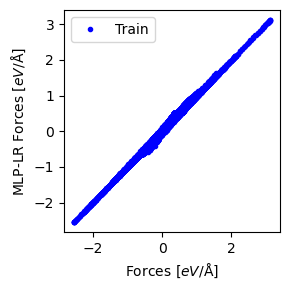

In [50]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, figsize=(3, 3))

ax1.plot(train_f_true[:,1], pred_train['forces'][:,1], '.', color='blue', label='Train')

ax1.set_xlabel('Forces [$eV/\mathrm{\AA}$]')

ax1.set_ylabel('MLP-LR Forces [$eV/\mathrm{\AA}$]')
ax1.legend()

plt.tight_layout()
plt.show()

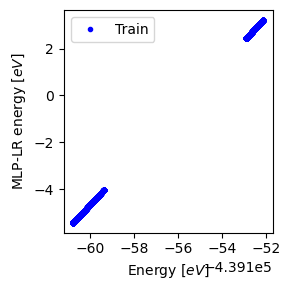

In [51]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, figsize=(3, 3))
ax1.plot(train_energy, pred_train['energy'], '.', color='blue', label='Train')

ax1.set_xlabel('Energy [$eV$]')

ax1.set_ylabel('MLP-LR energy [$eV$]')
ax1.legend()

plt.tight_layout()
plt.show()